In [7]:
import os
import numpy as np
import ipynb
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from scipy.stats import levene, wilcoxon, ttest_rel
from cliffs_delta import cliffs_delta
from ipynb.fs.defs.functions_and_classes import *

In [8]:
#model = 'word2vec'
model = 'glove'
#model = 'fasttext'
dim = 300
#language = 'he'
language = 'en'
#suffix_pair = ['ity', 'ness']
suffix_pair = ['al', 'less']
suff1, suff2 = suffix_pair

In [9]:
fname = f'{model}_{dim}_{language}_vectors_reduced.txt'
embedding = build_dict_from_vector_file('./models/reduced/', fname)
if language == 'he':
    path_to_dataset = './datasets/he/definitive_dataset.csv'
if language == 'en':
    path_to_dataset = f'./datasets/en/{suff1}_{suff2}_dataset_filtered.csv'
dataset = load_dataset_from_csv(language, path_to_dataset)
dataset.filter_against_embedding(embedding)

Processed 0
Embedding entries: 176
Embedding dimension: 96
Number of datapoints before adjustment: 205
Number of datapoints after adjustment: 59


In [10]:
triplets = dataset.get_triplets()
print(triplets)

[['accent', 'accentual', 'accentless'], ['action', 'actional', 'actionless'], ['author', 'authorial', 'authorless'], ['bride', 'bridal', 'brideless'], ['case', 'casual', 'caseless'], ['cause', 'causal', 'causeless'], ['cement', 'cemental', 'cementless'], ['center', 'central', 'centerless'], ['client', 'cliental', 'clientless'], ['crust', 'crustal', 'crustless'], ['dimension', 'dimensional', 'dimensionless'], ['direction', 'directional', 'directionless'], ['disk', 'discal', 'diskless'], ['distortion', 'distortional', 'distortionless'], ['duration', 'durational', 'durationless'], ['emotion', 'emotional', 'emotionless'], ['event', 'eventual', 'eventless'], ['exception', 'exceptional', 'exceptionless'], ['expression', 'expressional', 'expressionless'], ['face', 'facial', 'faceless'], ['feature', 'featural', 'featureless'], ['form', 'formal', 'formless'], ['foundation', 'foundational', 'foundationless'], ['friction', 'frictional', 'frictionless'], ['front', 'frontal', 'frontless'], ['functi

In [75]:
def compute_similarities(embedding, triplets, mode='mean', ref='noun'):
    """ If ref is 'noun', we collect noun/denominal and noun/other verb sims;
    if ref is 'denominal' we collect denominal/noun and denominal/other verb sims."""

    sims_n_dn = []
    sims_ref_ndn = []
    best_ndns = []
    for triplet in triplets:
        print(triplet)
        n = triplet[0]
        dn = triplet[1]
        ndns = triplet[2] #DO WE ALSO CONSIDER THE OTHER ROOT DERIVED ELEMENTS????
        
        sim_n_dn = 1 - cosine(embedding[n], embedding[dn])
        sims_n_dn.append(sim_n_dn)
        
        
        if ref =='noun':
            reference = n
        if ref == 'denominal':
            reference = dn
            
        if mode == 'best':
            index_best_ndn = np.argmax([1 - cosine(embedding[reference], embedding[ndn]) for ndn in ndns])
            best_ndn = ndns[index_best_ndn]
            best_ndn_vec = embedding[best_ndn]
            best_ndns.append(best_ndn)
            sim_ref_ndn = 1 - cosine(embedding[reference], best_ndn_vec)

        if mode == 'mean':
            #other_vec = np.mean([embedding[other_verb] for other_verb in other_verbs], axis=0)
            sim_ref_ndn = np.mean([1 - cosine(embedding[reference], embedding[ndn]) for ndn in ndns], axis=0)

        sims_ref_ndn.append(sim_ref_ndn)

    return (sims_n_dn, sims_ref_ndn, best_ndns)

In [76]:
if language == 'he':
    sims_n_dn, sims_ref_ndn, best_ndns = compute_similarities(embedding, triplets, mode=mode, ref=ref)

['מחשב', 'למחשב', ['לחשב', 'להתחשב', 'לחשוב', 'להחשיב', 'להיחשב']]
['תחזוקה', 'לתחזק', ['לחזק', 'להתחזק', 'להחזיק']]
['חשבון', 'להתחשבן', ['לחשב', 'להתחשב', 'לחשוב', 'להחשיב', 'להיחשב']]
['תקשורת', 'לתקשר', ['לקשר', 'להתקשר', 'לקשור', 'להיקשר']]
['תפקידים', 'לתפקד', ['לפקד', 'להתפקד', 'לפקוד', 'להפקיד', 'להיפקד']]
['תרגילים', 'לתרגל', ['לרגל', 'להתרגל', 'להרגיל']]
['תזמורת', 'לתזמר', ['לזמר']]
['אבטחה', 'לאבטח', ['לבטח', 'לבטוח', 'להבטיח']]
['קמצן', 'להתקמצן', ['לקמץ']]
['מרכז', 'למרכז', ['לרכז', 'להתרכז']]
['מרכז', 'להתמרכז', ['לרכז', 'להתרכז']]
['מסגרת', 'למסגר', ['להסתגר', 'לסגור', 'להסגיר', 'להיסגר']]
['תעתיקים', 'לתעתק', ['להעתיק']]
['תמריצים', 'לתמרץ', ['להמריץ']]
['תצפית', 'לתצפת', ['לצפות']]
['אבחנות', 'לאבחן', ['לבחון', 'להבחין', 'להיבחן']]
['תחקיר', 'לתחקר', ['לחקור', 'להיחקר']]
['תקליטים', 'לתקלט', ['לקלוט', 'להקליט', 'להיקלט']]
['אזכרות', 'לאזכר', ['לזכור', 'להזכיר', 'להיזכר']]
['מספר', 'למספר', ['לספר', 'להסתפר', 'לספור', 'להיספר']]
['מרפק', 'למרפק', ['להתרפק']]
['מסמר', '

In [77]:
def test_diff(sims_n_dn, sims_ref_ndn):
    diff_sims_dn_ndn = np.array(sims_n_dn) - np.array(sims_ref_ndn)
    print(f'Sample size: {len(diff_sims_dn_ndn)}')
    plt.hist(diff_sims_dn_ndn)
    plt.show()

    std = np.std(diff_sims_dn_ndn)
    mean = np.mean(diff_sims_dn_ndn)
    outp = [mean, std]
    print(f'Standard deviation: {std}')
    print(f'Mean: {mean}')

    _, p = levene(sims_n_dn, sims_ref_ndn)
    print(f'Levene p: {p}')

    if p > .05:
        print("F-test failed, performing Wilcoxon")
        outp.append('w')
        _, p = wilcoxon(sims_n_dn, sims_ref_ndn, zero_method='wilcox', correction=False, alternative='greater')
    else:
        print("F-test succeeded, performing t-test")
        outp.append('t')
        _, p = ttest_rel(sims_n_dn, sims_ref_ndn, alternative='greater')
        
    d, res = cliffs_delta(sims_n_dn, sims_ref_ndn)
    
    print(f'P-value: {p}')
    print(f'Effect size (Cliff\'s delta): {d} ({res})')
    outp.extend([p, d, res])

    return diff_sims_dn_ndn, outp


Sample size: 32


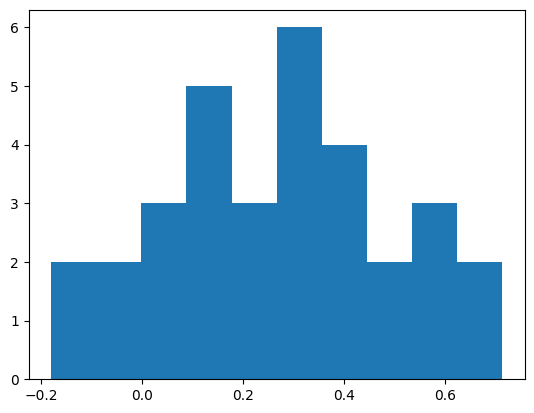

Standard deviation: 0.23086414150632512
Mean: 0.2664197182543431
Levene p: 0.04440471746557738
F-test succeeded, performing t-test
P-value: 1.8403852762393982e-07
Effect size (Cliff's delta): 0.70703125 (large)


In [78]:
if language == 'he':
    diff_sims_dn_ndn, outp = test_diff(sims_n_dn, sims_ref_ndn)

In [80]:
def save_report(model, dim, language, mode, ref, outp):
    mean, std, test, p, d, res = outp
    fname = f'{model}_{dim}_{language}_{mode}_{ref}_report.txt'
    with open(f'./reports/{fname}', 'w') as f:
        f.write(f'Mean: {mean}\n')
        f.write(f'Std: {std}\n')
        f.write(f'Test: {test}\n')
        f.write(f'P-value: {p}\n')
        f.write(f"Cliff' s delta': {d}\n")
        f.write(f'Effect: {res}\n')


In [81]:
if language == 'he':
    save_report(model, dim, language, mode, ref, outp)

In [11]:
def compute_affixal_vecs(embedding, triplets):
    suff_1_vecs = []
    suff_2_vecs = []
    for t in triplets:
        suff1_vec = embedding[t[1]]-embedding[t[0]]
        suff2_vec = embedding[t[2]]-embedding[t[0]]
        suff_1_vecs.append(suff1_vec)
        suff_2_vecs.append(suff2_vec)
    return suff_1_vecs, suff_2_vecs
        

In [12]:
suff_1_vecs, suff_2_vecs = compute_affixal_vecs(embedding, triplets)

In [14]:
len(suff_1_vecs[0])

96

In [17]:
def reduce_2d(vecs, algorithm):
    if algorithm == 'pca':
        model = PCA(n_components=2)
        model.fit(vecs)
        print(f'Explained variance: {np.sum(model.explained_variance_ratio_)}')
        print(f'Explained variance per component: {(model.explained_variance_ratio_)}')
    if algorithm == 'kernel-pca':
        model = KernelPCA(n_components=2, kernel='cosine')
        model.fit(vecs)
    return model

def suffix_effect_2d(embedding, base_affixed_pairs, sample_size, n_runs, algorithm):
    for _ in range(n_runs):
        pairs_sample = random.sample(base_affixed_pairs, sample_size)
        base_sample = [p[0] for p in pairs_sample]
        affixed_sample = [p[1] for p in pairs_sample]
        base_vecs = [embedding[a] for a in base_sample]
        affixed_vecs = [embedding[n] for n in affixed_sample]
        model = reduce_2d(base_vecs+affixed_vecs, algorithm)
        base_vecs_reduced = model.transform(base_vecs)
        affixed_vecs_reduced = model.transform(affixed_vecs)
        
        for i, (base, affixed) in enumerate(pairs_sample):
            base_vec = base_vecs[i]
            affixed_vec = affixed_vecs[i]
            plt.scatter([base_vec[0], affixed_vec[0]], [base_vec[1], affixed_vec[1]])
            plt.plot([base_vec[0], affixed_vec[0]], [base_vec[1], affixed_vec[1]], linestyle='dashed', color='grey')
            plt.annotate(base, (base_vec[0], base_vec[1]))
            plt.annotate(affixed, (affixed_vec[0], affixed_vec[1]))
        plt.show()

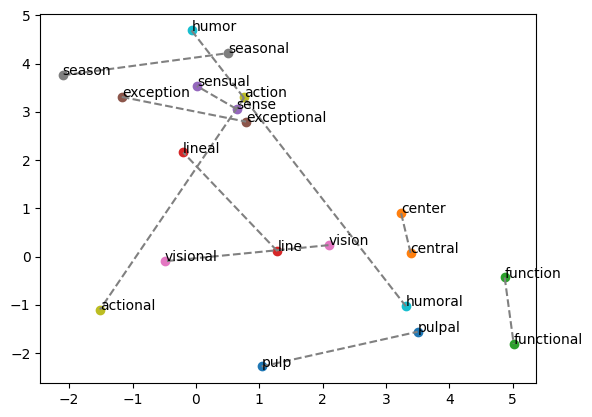

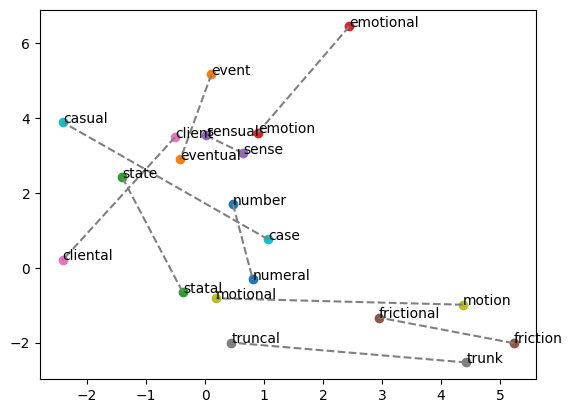

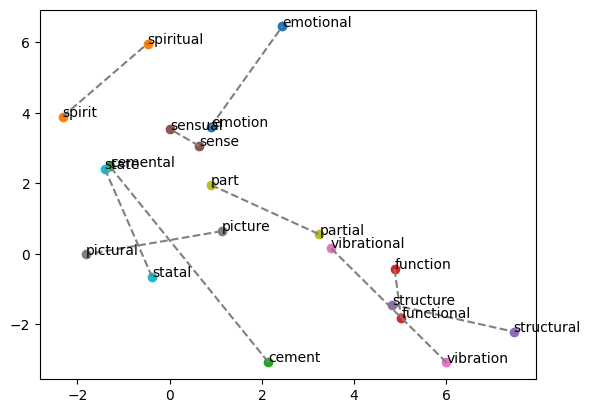

In [20]:
import random
from sklearn.decomposition import KernelPCA
suffix_effect_2d(embedding, [[t[0], t[1]] for t in triplets], 10, 3, 'kernel-pca')

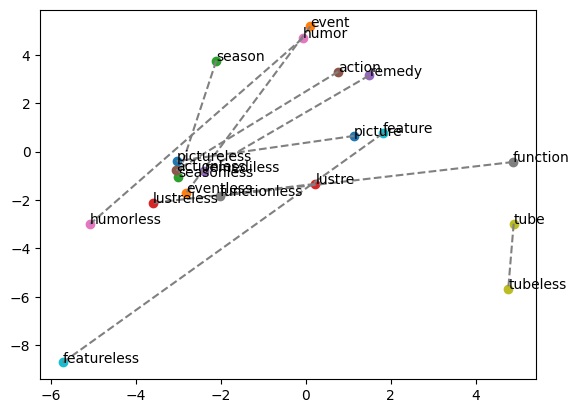

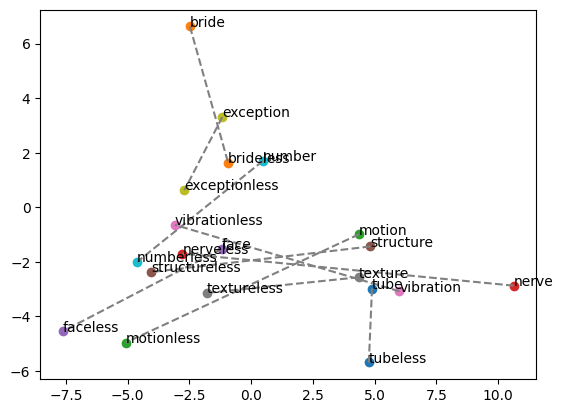

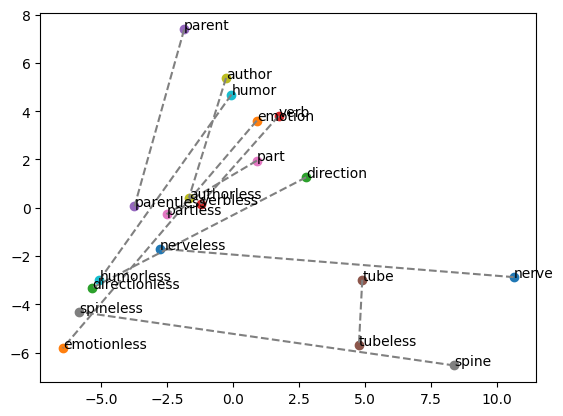

In [21]:
suffix_effect_2d(embedding, [[t[0], t[2]] for t in triplets], 10, 3, 'kernel-pca')